In [514]:
from xml.etree import ElementTree as ET
from svgpathtools import parse_path
from svgpathtools.parser import parse_transform
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection
from shapely.geometry import GeometryCollection

import sys
sys.path.append('../')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg,
    crop_and_save_tile,
)


## Read the ghiri SVG file

In [515]:
# tree = ET.parse('./ghiri_pattern.svg')
# tree = ET.parse('./geometrias_persas_solo.svg')
tree = ET.parse('./persian_geometry_final.svg')
root = tree.getroot()

# Un-Apply Transforms from the SVG file

In [516]:
def multiply_transforms(t1, t2):
    """Multiply two transform matrices"""
    if t1 is None:
        return t2
    if t2 is None:
        return t1
    # Both are already 3x3 numpy arrays
    return t1 @ t2

def apply_transform_to_path(path, transform):
    """Apply a transform matrix to a path"""
    if transform is None:
        return path
    
    # Create a function to transform a complex number (point)
    def transform_point(z):
        x, y = z.real, z.imag
        # Transform uses matrix multiplication: [x', y', 1] = [x, y, 1] @ transform.T
        point = np.array([x, y, 1])
        transformed = transform @ point
        return complex(transformed[0], transformed[1])
    
    # Transform each segment in the path
    from svgpathtools import Path, Line, CubicBezier
    new_segments = []
    for seg in path:
        if isinstance(seg, Line):
            new_segments.append(Line(transform_point(seg.start), transform_point(seg.end)))
        elif isinstance(seg, CubicBezier):
            new_segments.append(CubicBezier(
                transform_point(seg.start),
                transform_point(seg.control1),
                transform_point(seg.control2),
                transform_point(seg.end)
            ))
        else:
            new_segments.append(seg)
    
    return Path(*new_segments)

In [517]:
def extract_paths_with_transforms(root):
    """Recursively extract all paths with their accumulated transforms"""
    paths = []
    
    def traverse(element, accumulated_transform=None):
        # Get transform for current element
        transform_str = element.get('transform')
        current_transform = parse_transform(transform_str) if transform_str else None
        
        # Combine with accumulated transform
        combined_transform = multiply_transforms(accumulated_transform, current_transform)
        
        # If this is a path, add it with its transform
        if element.tag == '{http://www.w3.org/2000/svg}path':
            path_data = parse_path(element.get('d'))
            transformed_path = apply_transform_to_path(path_data, combined_transform)
            paths.append(transformed_path)
        
        # Recurse into children
        for child in element:
            traverse(child, combined_transform)
    
    traverse(root)
    return paths

# Extract all paths with transforms applied
transformed_paths = extract_paths_with_transforms(root)
print(f"Extracted {len(transformed_paths)} paths with transforms applied")

Extracted 269 paths with transforms applied


## Convert paths to Shapely geometries

In [518]:
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely import affinity
from shapely.ops import unary_union

def path_to_shapely(path):
    """Convert an SVG path to a Shapely geometry (Polygon or LineString)"""
    # Extract all points from the path
    points = []
    for seg in path:
        points.append((seg.start.real, seg.start.imag))
    # Add the last point
    if len(path) > 0:
        points.append((path[-1].end.real, path[-1].end.imag))
    
    if len(points) < 2:
        return None
    
    # Check if path is closed (first and last points are very close)
    start = points[0]
    end = points[-1]
    is_closed = abs(start[0] - end[0]) < 0.01 and abs(start[1] - end[1]) < 0.01
    
    if is_closed and len(points) >= 4:  # Need at least 4 points for a polygon (including duplicate start/end)
        return Polygon(points)
    else:
        return LineString(points)

# Convert all paths to Shapely geometries
shapely_geometries = []
for path in transformed_paths:
    geom = path_to_shapely(path)
    if geom is not None:
        shapely_geometries.append(geom)

print(f"Converted {len(shapely_geometries)} paths to Shapely geometries")

# Count polygons vs lines
num_polygons = sum(1 for g in shapely_geometries if isinstance(g, Polygon))
num_lines = sum(1 for g in shapely_geometries if isinstance(g, LineString))
print(f"Polygons: {num_polygons}, LineStrings: {num_lines}")

Converted 269 paths to Shapely geometries
Polygons: 269, LineStrings: 0


In [519]:
def plot_full_set(full_set, all_frames):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot polygons 
    for geom in full_set:
        if isinstance(geom, Polygon):
            coords = list(geom.exterior.coords)
            polygon = MPLPolygon(coords, fill=False, edgecolor='blue', linewidth=0.5)
            ax.add_patch(polygon)
        elif isinstance(geom, LineString):
            coords = list(geom.coords)
            ax.plot([p[0] for p in coords], [p[1] for p in coords], 'k-', linewidth=0.5)

    for in_out_frames in all_frames:
        geom = in_out_frames[0] # inner frame
        coords = list(geom.exterior.coords)
        polygon = MPLPolygon(coords, fill=False, edgecolor='red', linewidth=1.5)
        ax.add_patch(polygon)
        
        geom = in_out_frames[1] # outer frame
        coords = list(geom.exterior.coords)
        polygon = MPLPolygon(coords, fill=False, edgecolor='red', linewidth=1.5)
        ax.add_patch(polygon)
            
    ax.set_aspect('equal')
    ax.autoscale()
    ax.invert_yaxis()  # SVG coordinates have Y increasing downward
    plt.title(f'Shapely Geometries: {num_polygons} polygons, {num_lines} lines')
    plt.show()


def plot_cropped_geometries(frame, cropped_geometries):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the frame
    frame_coords = list(frame.exterior.coords)
    frame_patch = MPLPolygon(frame_coords, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(frame_patch)

    # Plot cropped geometries
    for geom in cropped_geometries:
        if isinstance(geom, Polygon):
            coords = list(geom.exterior.coords)
            polygon = MPLPolygon(coords, fill=False, edgecolor='blue', linewidth=0.5)
            ax.add_patch(polygon)
        elif isinstance(geom, LineString):
            coords = list(geom.coords)
            ax.plot([p[0] for p in coords], [p[1] for p in coords], 'k-', linewidth=0.5)

    ax.set_aspect('equal')
    ax.autoscale()
    ax.invert_yaxis()
    plt.show()

## Make copies of the geometries
And translate them down

In [520]:
def make_copies(geometries, y_offset):
    # y_offset = -220 works
    geom_copies = []
    for geom in geometries:
        geom = affinity.translate(geom, 0, y_offset)
        geom_copies.append(geom)
    return geom_copies

full_set = []
for i in range(9):
    geom_copies = make_copies(shapely_geometries, 240*i)
    full_set += geom_copies

# Crop polygons 
def crop_geometries(geometries, frame):
    # Crop all geometries to the frame
    cropped_geometries = []

    for geom in geometries:  # Use the geometries parameter instead of shapely_geometries
        if geom.intersects(frame):
            cropped = geom.intersection(frame)
            # intersection can return various types, so handle them
            if not cropped.is_empty:
                cropped_geometries.append(cropped)
    
    # remove holes that are too small
    final_cropped_geometries = [
        p for p in cropped_geometries
        if hasattr(p, 'area') and p.area >= 21
        ]

    print(f"Cropped geometries: {len(final_cropped_geometries)}")

    # Count types in cropped geometries
    from shapely.geometry import MultiLineString, MultiPolygon, GeometryCollection
    num_cropped_polygons = sum(1 for g in final_cropped_geometries if isinstance(g, Polygon))
    num_cropped_lines = sum(1 for g in final_cropped_geometries if isinstance(g, LineString))
    num_multi = sum(1 for g in final_cropped_geometries if isinstance(g, (MultiLineString, MultiPolygon, GeometryCollection)))
    print(f"Polygons: {num_cropped_polygons}, LineStrings: {num_cropped_lines}, Multi/Collections: {num_multi}")

    return final_cropped_geometries

In [521]:
(166-146)/2, 905-885

(10.0, 20)

In [522]:
# Create frame
from shapely import affinity
inner_frame = Polygon([(0,0),(885,0),(885,116),(0,116)])
outer_frame = Polygon([(0,0),(908,0),(908,167),(0,167)])

Y_OFFSET = 240
Y_START = 1705

X_OFFSET = 10
IN_MARGIN = 10.5

UP_SHIFT = 4

all_frames = []

for i in range(8):
    all_frames.append(
        (affinity.translate(inner_frame, X_OFFSET + IN_MARGIN,  Y_START + 30 - (Y_OFFSET + UP_SHIFT)*i), # inner frame
        affinity.translate(outer_frame, X_OFFSET,  Y_START - (Y_OFFSET + UP_SHIFT)*i))) # outer frame

final_inner_frame = Polygon([(0,0),(885,0),(885,150),(0,150)])
final_outer_frame = Polygon([(0,0),(908,0),(908,184),(0,184)])

all_frames.append(
    (affinity.translate(final_inner_frame, X_OFFSET + IN_MARGIN,  Y_START + 15 + (Y_OFFSET - UP_SHIFT) - 8), 
    affinity.translate(final_outer_frame, X_OFFSET,  Y_START + (Y_OFFSET - UP_SHIFT) - 8))
)


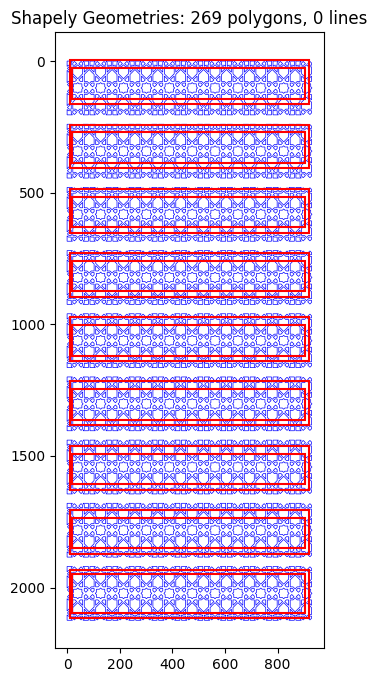

In [523]:
plot_full_set(full_set, all_frames)

In [524]:
cropped_geometries1 = crop_geometries(full_set, all_frames[0][0])
cropped_geometries2 = crop_geometries(full_set, all_frames[1][0])
cropped_geometries3 = crop_geometries(full_set, all_frames[2][0])
cropped_geometries4 = crop_geometries(full_set, all_frames[3][0])
cropped_geometries5 = crop_geometries(full_set, all_frames[4][0])
cropped_geometries6 = crop_geometries(full_set, all_frames[5][0])
cropped_geometries7 = crop_geometries(full_set, all_frames[6][0])
cropped_geometries8 = crop_geometries(full_set, all_frames[7][0])
cropped_geometries9 = crop_geometries(full_set, all_frames[8][0])

Cropped geometries: 155
Polygons: 155, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 135
Polygons: 135, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 135
Polygons: 135, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 135
Polygons: 135, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 135
Polygons: 135, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 155
Polygons: 155, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 154
Polygons: 154, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 154
Polygons: 154, LineStrings: 0, Multi/Collections: 0
Cropped geometries: 175
Polygons: 175, LineStrings: 0, Multi/Collections: 0


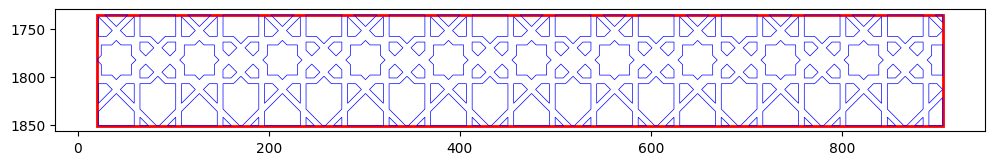

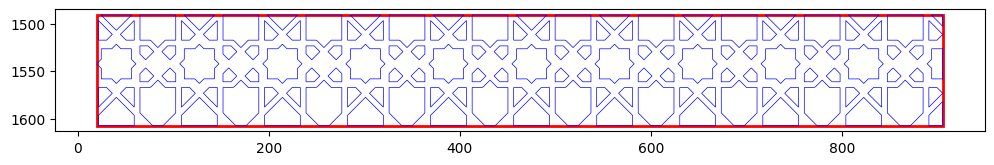

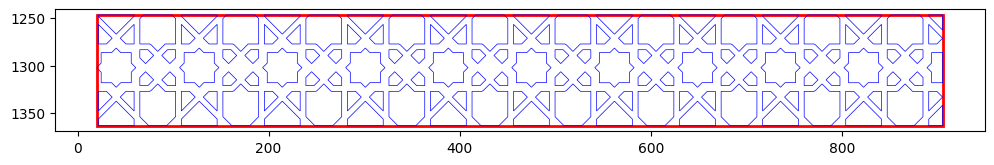

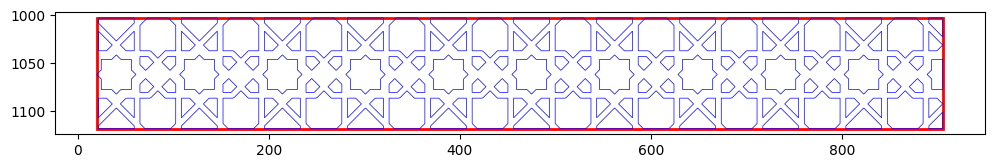

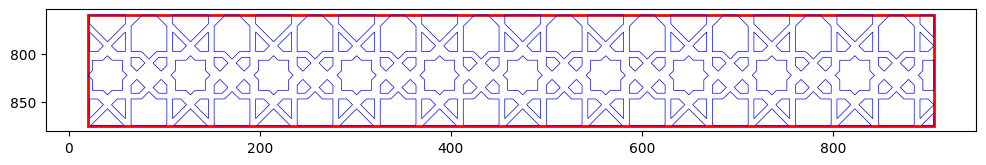

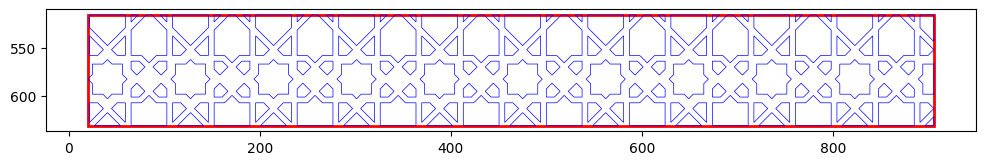

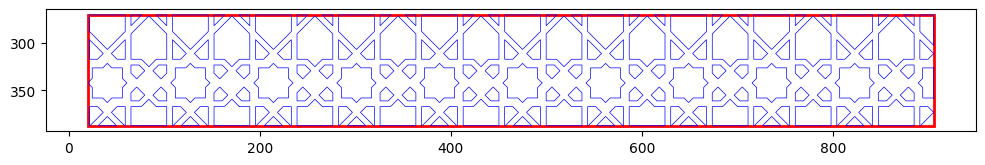

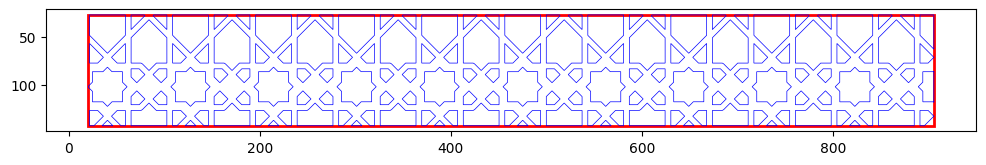

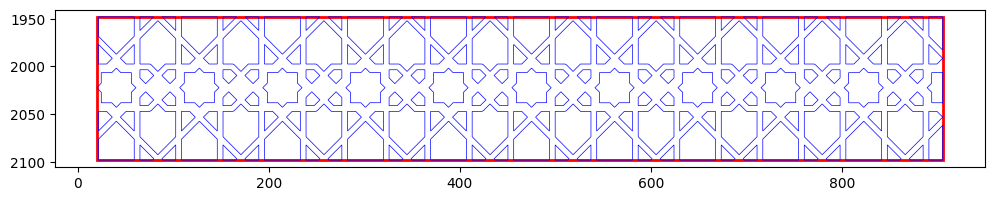

In [525]:
plot_cropped_geometries(all_frames[0][0], cropped_geometries1)
plot_cropped_geometries(all_frames[1][0], cropped_geometries2)
plot_cropped_geometries(all_frames[2][0], cropped_geometries3)
plot_cropped_geometries(all_frames[3][0], cropped_geometries4)
plot_cropped_geometries(all_frames[4][0], cropped_geometries5)
plot_cropped_geometries(all_frames[5][0], cropped_geometries6)
plot_cropped_geometries(all_frames[6][0], cropped_geometries7)
plot_cropped_geometries(all_frames[7][0], cropped_geometries8)
plot_cropped_geometries(all_frames[8][0], cropped_geometries9)

In [526]:
def shapely_to_svg_path(geom):
    """Convert a Shapely geometry to an SVG path string"""
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        path_parts = [f"M {coords[0][0]},{coords[0][1]}"]
        for x, y in coords[1:]:
            path_parts.append(f"L {x},{y}")
        path_parts.append("Z")
        return (" ".join(path_parts), "polygon")
    elif isinstance(geom, LineString):
        coords = list(geom.coords)
        path_parts = [f"M {coords[0][0]},{coords[0][1]}"]
        for x, y in coords[1:]:
            path_parts.append(f"L {x},{y}")
        return (" ".join(path_parts), "line")
    return ""

In [527]:
save_polygon_list_to_svg(cropped_geometries1 + [all_frames[0][1]], filename='tabica_4.1.svg')
save_polygon_list_to_svg(cropped_geometries2 + [all_frames[1][1]], filename='tabica_4.2.svg')
save_polygon_list_to_svg(cropped_geometries3 + [all_frames[2][1]], filename='tabica_4.3.svg')
save_polygon_list_to_svg(cropped_geometries4 + [all_frames[3][1]], filename='tabica_4.4.svg')
save_polygon_list_to_svg(cropped_geometries5 + [all_frames[4][1]], filename='tabica_4.5.svg')
save_polygon_list_to_svg(cropped_geometries6 + [all_frames[5][1]], filename='tabica_4.6.svg')
save_polygon_list_to_svg(cropped_geometries7 + [all_frames[6][1]], filename='tabica_4.7.svg')
save_polygon_list_to_svg(cropped_geometries8 + [all_frames[7][1]], filename='tabica_4.8.svg')
